In [96]:
%%capture
%load_ext autoreload
%autoreload 2
from setup_nb_env import *

from epsampling.utils import load_csv
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
from epsampling.utils import drop_sers_with_nans
from epsampling.utils import date_str_to_int

DATA_DIR = '/work/users/k/4/k4thryn/Repos/EpSampling/data/'
DT = datetime.today().strftime('%Y%m%d-%H%M%S')

from IPython.display import Audio

def meow():
    display(Audio(filename='../cat_meow2.wav', autoplay=True))

In [128]:
# # # # MTS COVARIATES # # # #

p = os.path.join(DATA_DIR,'raw', 'Covid19_01262020_09262020.csv')
df = pd.read_csv(p)
# df

cols = [x for x in df.columns if x not in ['index','Date','confirmed_cases','deaths','foot_traffic']]
df = df[cols]

df['Fips'] = df.GISJOIN.apply(lambda x: x[1:3] + x[4:-1])
df['Fips'] = df.Fips.apply(lambda x: int(x))
df.drop_duplicates(inplace=True)
df.drop('GISJOIN',axis=1,inplace=True)
df.set_index('Fips',inplace=True,drop=True)


# # # # DEATH DATA # # # #

timestamp = '20241009-144131'

fpath = os.path.join(DATA_DIR,'processed', f'processed_naive_deaths_{timestamp}.csv')
df_deaths = pd.read_csv(fpath)
## Drop rows with nans.
df_deaths.dropna(inplace=True)
## Drop samples with negative inc deaths.
df_deaths = df_deaths[df_deaths.True_inc_deaths >= 0]

df = df_deaths.join(df,on='Fips')
df = df[df.Date < 20210626]
display(df)

,Fips,State_fips,Pop,State_pop,Ratio,Date,Proj_inc_deaths,True_cum_deaths,Cum_deaths_tm1,True_inc_deaths,...,OCCU1,OCCU2,OCCU3,OCCU4,OCCU5,DT,HD,HT,WI,OB
1,1001,1,58239.0,4997675,0.011653,20200620,83.302156,9.0,6.0,3.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
2,1001,1,58239.0,4997675,0.011653,20200627,68.179357,12.0,9.0,3.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
3,1001,1,58239.0,4997675,0.011653,20200704,76.238975,13.0,12.0,1.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
4,1001,1,58239.0,4997675,0.011653,20200711,88.362530,15.0,13.0,2.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
5,1001,1,58239.0,4997675,0.011653,20200718,114.279381,21.0,15.0,6.0,...,38.70,15.94,22.10,8.24,15.02,9.9,200.6,93.2,8.7,33.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309908,56045,56,6891.0,576641,0.011950,20210522,2.000000,5.0,5.0,0.0,...,31.78,14.27,16.37,20.89,16.69,8.6,144.8,76.2,6.0,41.9
309909,56045,56,6891.0,576641,0.011950,20210529,2.000000,5.0,5.0,0.0,...,31.78,14.27,16.37,20.89,16.69,8.6,144.8,76.2,6.0,41.9
309910,56045,56,6891.0,576641,0.011950,20210605,3.000000,6.0,5.0,1.0,...,31.78,14.27,16.37,20.89,16.69,8.6,144.8,76.2,6.0,41.9
309911,56045,56,6891.0,576641,0.011950,20210612,2.000000,6.0,6.0,0.0,...,31.78,14.27,16.37,20.89,16.69,8.6,144.8,76.2,6.0,41.9


### <font color=blue> Prep data. Choose deaths transformation.

In [129]:
from epsampling.modeling import get_full_modeling_dfs

# df, df_acs = get_full_modeling_dfs(timestamp='20241009-144131')

df = df[df.True_inc_deaths > 0]
df = df[df.Naive_inc_deaths > 0]
df = df[df.Proj_inc_deaths > 0]
df = df[df.Cum_deaths_tm1 > 0]


# df['Target'] = df.apply(lambda x: (x.True_inc_deaths+1) / x.Pop * 100000, axis=1)
# df['Naive'] = df.apply(lambda x: (x.Naive_inc_deaths+1) / x.Pop * 100000, axis=1)
# df['State_deaths'] = df.apply(lambda x: (x.Proj_inc_deaths+1) / x.State_pop * 100000, axis=1)
# df['Cumtm1'] = df.apply(lambda x: (x.Cum_deaths_tm1+1) / x.Pop * 100000, axis=1)

# df['Target'] = df.apply(lambda x: (x.True_inc_deaths+2) / x.Pop * 100000, axis=1)
# df['Naive'] = df.apply(lambda x: (x.Naive_inc_deaths+2) / x.Pop * 100000, axis=1)
# df['State_deaths'] = df.apply(lambda x: (x.Proj_inc_deaths+2) / x.State_pop * 100000, axis=1)
# df['Cumtm1'] = df.apply(lambda x: (x.Cum_deaths_tm1+2) / x.Pop * 100000, axis=1)

# df['Target'] = df.apply(lambda x: (x.True_inc_deaths+1) / x.Pop, axis=1)
# df['Naive'] = df.apply(lambda x: (x.Naive_inc_deaths+1) / x.Pop, axis=1)
# df['State_deaths'] = df.apply(lambda x: (x.Proj_inc_deaths+1) / x.State_pop, axis=1)
# df['Cumtm1'] = df.apply(lambda x: (x.Cum_deaths_tm1+1) / x.Pop, axis=1)

# df['Target'] = df.apply(lambda x: np.log10(x.True_inc_deaths), axis=1)
# df['Naive'] = df.apply(lambda x: np.log10(x.Naive_inc_deaths), axis=1)
# df['State_deaths'] = df.apply(lambda x: np.log10(x.Proj_inc_deaths), axis=1)
# df['Cumtm1'] = df.apply(lambda x: np.log10(x.Cum_deaths_tm1), axis=1)

df['Target'] = df.apply(lambda x: np.log10(x.True_inc_deaths+1), axis=1)
df['Naive'] = df.apply(lambda x: np.log10(x.Naive_inc_deaths+1), axis=1)
df['State_deaths'] = df.apply(lambda x: np.log10(x.Proj_inc_deaths+1), axis=1)
df['Cumtm1'] = df.apply(lambda x: np.log10(x.Cum_deaths_tm1+1), axis=1)

### <font color=magenta> Remove outliers.

In [130]:
from scipy import stats

df = df[np.abs(stats.zscore(df.Target)) < 5]
display(df)

,Fips,State_fips,Pop,State_pop,Ratio,Date,Proj_inc_deaths,True_cum_deaths,Cum_deaths_tm1,True_inc_deaths,...,OCCU5,DT,HD,HT,WI,OB,Target,Naive,State_deaths,Cumtm1
1,1001,1,58239.0,4997675,0.011653,20200620,83.302156,9.0,6.0,3.0,...,15.02,9.9,200.6,93.2,8.7,33.2,0.602060,0.294629,1.925839,0.845098
2,1001,1,58239.0,4997675,0.011653,20200627,68.179357,12.0,9.0,3.0,...,15.02,9.9,200.6,93.2,8.7,33.2,0.602060,0.253946,1.839977,1.000000
3,1001,1,58239.0,4997675,0.011653,20200704,76.238975,13.0,12.0,1.0,...,15.02,9.9,200.6,93.2,8.7,33.2,0.301030,0.276101,1.887836,1.113943
4,1001,1,58239.0,4997675,0.011653,20200711,88.362530,15.0,13.0,2.0,...,15.02,9.9,200.6,93.2,8.7,33.2,0.477121,0.307434,1.951155,1.146128
5,1001,1,58239.0,4997675,0.011653,20200718,114.279381,21.0,15.0,6.0,...,15.02,9.9,200.6,93.2,8.7,33.2,0.845098,0.367677,2.061752,1.204120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309793,56043,56,7768.0,576641,0.013471,20210206,28.000000,26.0,25.0,1.0,...,17.39,6.4,140.3,121.8,6.6,30.4,0.301030,0.138994,1.462398,1.414973
309884,56045,56,6891.0,576641,0.011950,20201205,40.000000,2.0,1.0,1.0,...,16.69,8.6,144.8,76.2,6.0,41.9,0.301030,0.169677,1.612784,0.301030
309889,56045,56,6891.0,576641,0.011950,20210109,32.000000,4.0,2.0,2.0,...,16.69,8.6,144.8,76.2,6.0,41.9,0.477121,0.140636,1.518514,0.477121
309893,56045,56,6891.0,576641,0.011950,20210206,28.000000,5.0,4.0,1.0,...,16.69,8.6,144.8,76.2,6.0,41.9,0.301030,0.125353,1.462398,0.698970


In [131]:
df_fips = pd.read_csv('state_fips.csv')
fips_to_st = {k:v for k,v in zip(df_fips.Fips, df_fips.Postal)}
# fips_to_st

### <font color=magenta> Add dummy variable for state.

In [132]:
dummies = pd.get_dummies(df['State_fips']).rename(columns=lambda x: 'Is_' + fips_to_st[x]  )
df = pd.concat([df, dummies], axis=1)
df.drop(['State_fips'], inplace=True, axis=1)
# df

### <font color=blue> Run models.

In [133]:
def line_plot(df, x_col, y_col, title=None):

    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.regplot(data=df, x=x_col, y=y_col, 
                scatter_kws={'s':10, 'alpha':0.5}, 
                line_kws={'color':'k','linewidth':0.5},logx=False)
    
    if title is not None:
        plt.title(title) 

    plt.show()

In [134]:
not_feats = ['Target','Fips', 'State_fips', 'Date',
       'Proj_inc_deaths', 'True_cum_deaths', 'Cum_deaths_tm1',
       'True_inc_deaths', 'Naive_inc_deaths','Target']

feats = [x for x in df.columns if x not in not_feats]

print(feats)

['Pop', 'State_pop', 'Ratio', 'TPOP', 'POPDEN', 'Metro', 'Micro', 'POP1', 'POP2', 'POP3', 'POP4', 'Race1', 'Race2', 'Race3', 'Race4', 'FHH', 'HHS1', 'HHS2', 'HHS3', 'SE1', 'EDU1', 'EDU2', 'EDU3', 'EDU4', 'EDU5', 'PL', 'HHI1', 'HHI2', 'HHI3', 'HHI4', 'HHI5', 'MHHI', 'MNR', 'MGR', 'MHV', 'HI', 'MHI', 'QTPOP_percentage', 'OCCU1', 'OCCU2', 'OCCU3', 'OCCU4', 'OCCU5', 'DT', 'HD', 'HT', 'WI', 'OB', 'Naive', 'State_deaths', 'Cumtm1', 'Is_AL', 'Is_AZ', 'Is_AR', 'Is_CA', 'Is_CO', 'Is_CT', 'Is_DE', 'Is_FL', 'Is_GA', 'Is_HI', 'Is_ID', 'Is_IL', 'Is_IN', 'Is_IA', 'Is_KS', 'Is_KY', 'Is_LA', 'Is_ME', 'Is_MD', 'Is_MA', 'Is_MI', 'Is_MN', 'Is_MS', 'Is_MO', 'Is_MT', 'Is_NE', 'Is_NV', 'Is_NH', 'Is_NJ', 'Is_NM', 'Is_NY', 'Is_NC', 'Is_ND', 'Is_OH', 'Is_OK', 'Is_OR', 'Is_PA', 'Is_RI', 'Is_SC', 'Is_SD', 'Is_TN', 'Is_TX', 'Is_UT', 'Is_VT', 'Is_VA', 'Is_WA', 'Is_WV', 'Is_WI', 'Is_WY']






============ TEST MONTH 7 ============

 > Deaths_Lasso
  • MAE: 	0.20285
  • MedAE: 	0.19479
  • MSE: 	0.06266
  • RMSE: 	0.25031
  • r-squared: 	0.43662
  • relMAE: 	6.2537
  • relMedAE: 	1.03439
 > Deaths_naive
  • MAE: 	0.21581
  • MedAE: 	0.17963
  • MSE: 	0.07931
  • RMSE: 	0.28162
  • r-squared: 	0.28688
  • relMAE: 	1.0
  • relMedAE: 	1.0


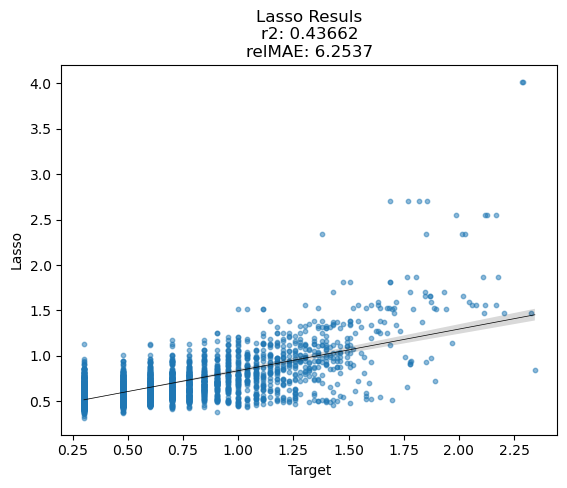

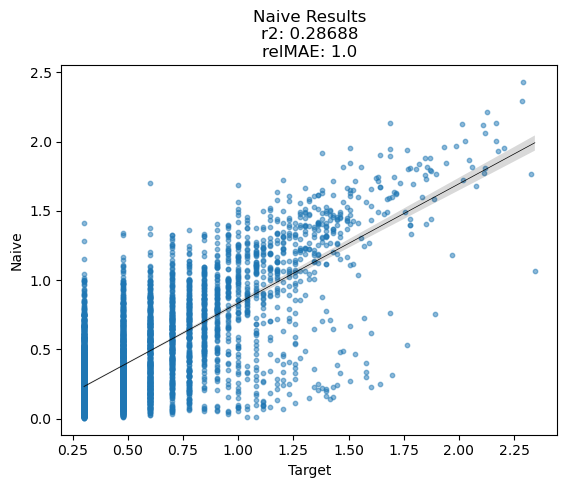

In [135]:
from epsampling.utils import get_chunks
from epsampling.modeling import get_date_chunked_splits, get_performance
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, ARDRegression, BayesianRidge
random.seed(666)

# # # # # # # # # # # # # # # # # # # #
num_runs = 4
# alg = 'Bayesian Ridge'
# alg = 'ARD Regression'
# alg = 'Linear'
alg = 'Lasso'
data_frac = 1.0
# # # # # # # # # # # # # # # # # # # #

chunks = get_chunks(list(df.Date.unique()), num_runs)

## Pre-selected test-train splits to product a good mae and a bad mae
idc = random.sample(range(len(chunks)), num_runs)
# idc = [14,12]
idc = [7]

models = []
preds = []
targets = []

for i,idx in enumerate(idc):
    
    ########## RUN MODEL ########## 
    
    df_train, df_test = get_date_chunked_splits(df, chunks, 
                                                idx, samp_frac=data_frac)
    
#     df_test = df_train
    
    ## Random split
#     from sklearn.model_selection import train_test_split
#     df_train, df_test = train_test_split(df, test_size=0.01, random_state=666)
    
#     feats = list(df_acs.columns) + ['State','Cumtm1','Naive',
#                                     'State_pop','Ratio','Pop']
        
    X_train = df_train[feats]
    X_test = df_test[feats]

    y_train = df_train['Target']
    
    y_test = df_test['Target']
    y_naive = df_test['Naive']
    
    if alg=='Linear':
        reg = LinearRegression().fit(X_train, y_train)
    elif alg=='Lasso':
        reg = Lasso(alpha=0.1).fit(X_train, y_train)
    elif alg=='Bayesian Ridge':
        reg = BayesianRidge(compute_score=True).fit(X_train, y_train)
    elif alg=='ARD Regression':
        reg = ARDRegression(compute_score=True).fit(X_train, y_train)
        
    models.append(reg)

    df_test[f'{alg}'] = reg.predict(X_test)

    ########## GET METRICS ##########

    model_names = [f'Deaths_{alg}', 'Deaths_naive']
    model_preds = [df_test[alg], df_test['Naive']]

    metrics_dict = get_performance(model_names, model_preds, y_test, y_naive)

    print(f'\n\n\n\n============ TEST MONTH {idx} ============\n')
    for k,v in metrics_dict.items():
        print(f' > {k}')
        for k2,v2 in v.items():
            if k2=='r2':
                k3 = 'r-squared'
            else:
                k3 = k2
            print(f'  • {k3}: \t{round(v2,5)}')
            
            
   ########## PLOTS ########## 
    
    ## Regression plot
    r2 = round(metrics_dict[f'Deaths_{alg}']['r2'],5)
    relmae = round(metrics_dict[f'Deaths_{alg}']['relMAE'],5)
    line_plot(df_test, 'Target', f'{alg}', 
              title=f'{alg} Results\nr2: {r2}\nrelMAE: {relmae}')
    
    ## Naive plot
    r2 = round(metrics_dict['Deaths_naive']['r2'],5)
    relmae = round(metrics_dict['Deaths_naive']['relMAE'],5)
    line_plot(df_test, 'Target', 'Naive', 
              title=f'Naive Results\nr2: {r2}\nrelMAE: {relmae}')


(array([2271.000000, 1005.000000, 492.000000, 283.000000, 220.000000,
        247.000000, 146.000000, 142.000000, 90.000000, 94.000000,
        68.000000, 54.000000, 20.000000, 21.000000, 14.000000, 13.000000,
        6.000000, 8.000000, 4.000000, 4.000000]),
 array([0.301030, 0.403198, 0.505366, 0.607534, 0.709702, 0.811871,
        0.914039, 1.016207, 1.118375, 1.220543, 1.322711, 1.424879,
        1.527047, 1.629215, 1.731384, 1.833552, 1.935720, 2.037888,
        2.140056, 2.242224, 2.344392]),
 <BarContainer object of 20 artists>)

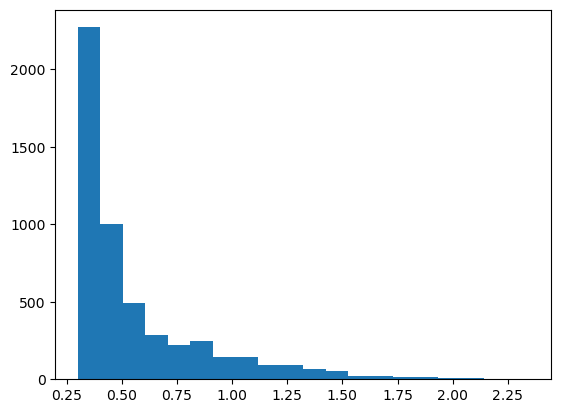

In [136]:
import matplotlib.pyplot as plt
plt.hist(df_test['Target'],bins=20)

In [118]:
df_test['Target']

50503     0.000000
46503     0.000000
204310    0.477121
289514    0.301030
35504     0.301030
            ...   
279816    0.698970
231679    0.845098
277420    0.000000
210109    0.000000
229378    0.000000
Name: Target, Length: 5205, dtype: float64

In [ ]:
fig_reg = LinearRegression().fit(df_test[['Target']], df_test[['Naive']])

In [ ]:
fig_reg.predict(df_test[['Target']])

In [ ]:
idx = df_test[['Naive']] > fig_reg.predict(df_test[['Target']])
idx = idx["Naive"].values
idx

In [ ]:
upper = df_test[idx]
# print(upper)
plt.scatter(upper['Target'], upper['Naive'])

lower = df_test[~idx]
plt.scatter(lower['Target'], lower['Naive'])

plt.show()

In [ ]:
upper.columns[:15]

In [ ]:
st_cols = [x for x in upper.columns if 'Is_' in x]
upper_sts = upper[st_cols]
df_original = pd.from_dummies(upper_sts, sep="_")
df_original.columns = ['Postal']
upper['Postal'] = df_original['Postal']


st_cols = [x for x in lower.columns if 'Is_' in x]
lower_sts = lower[st_cols]
df_original = pd.from_dummies(lower_sts, sep="_")
df_original.columns = ['Postal']
lower['Postal'] = df_original['Postal']

In [ ]:
upper.Metro.value_counts()

In [ ]:
plt.hist(upper.True_inc_deaths, bins = 100)
plt.hist(lower.True_inc_deaths, bins = 100)

In [ ]:
list(upper.columns)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

pd.DataFrame([upper.True_inc_deaths.describe(),
lower.True_inc_deaths.describe()])

In [ ]:
# pd.DataFrame([upper.Target.describe(),
# lower.Target.describe()])

In [ ]:
pd.DataFrame([upper.Naive_inc_deaths.describe(),
lower.Naive_inc_deaths.describe()])

In [ ]:
plt.hist(np.log10(upper.Date), bins = 20, alpha = 0.5)
plt.hist(np.log10(lower.Date), bins = 20, alpha = 0.5)

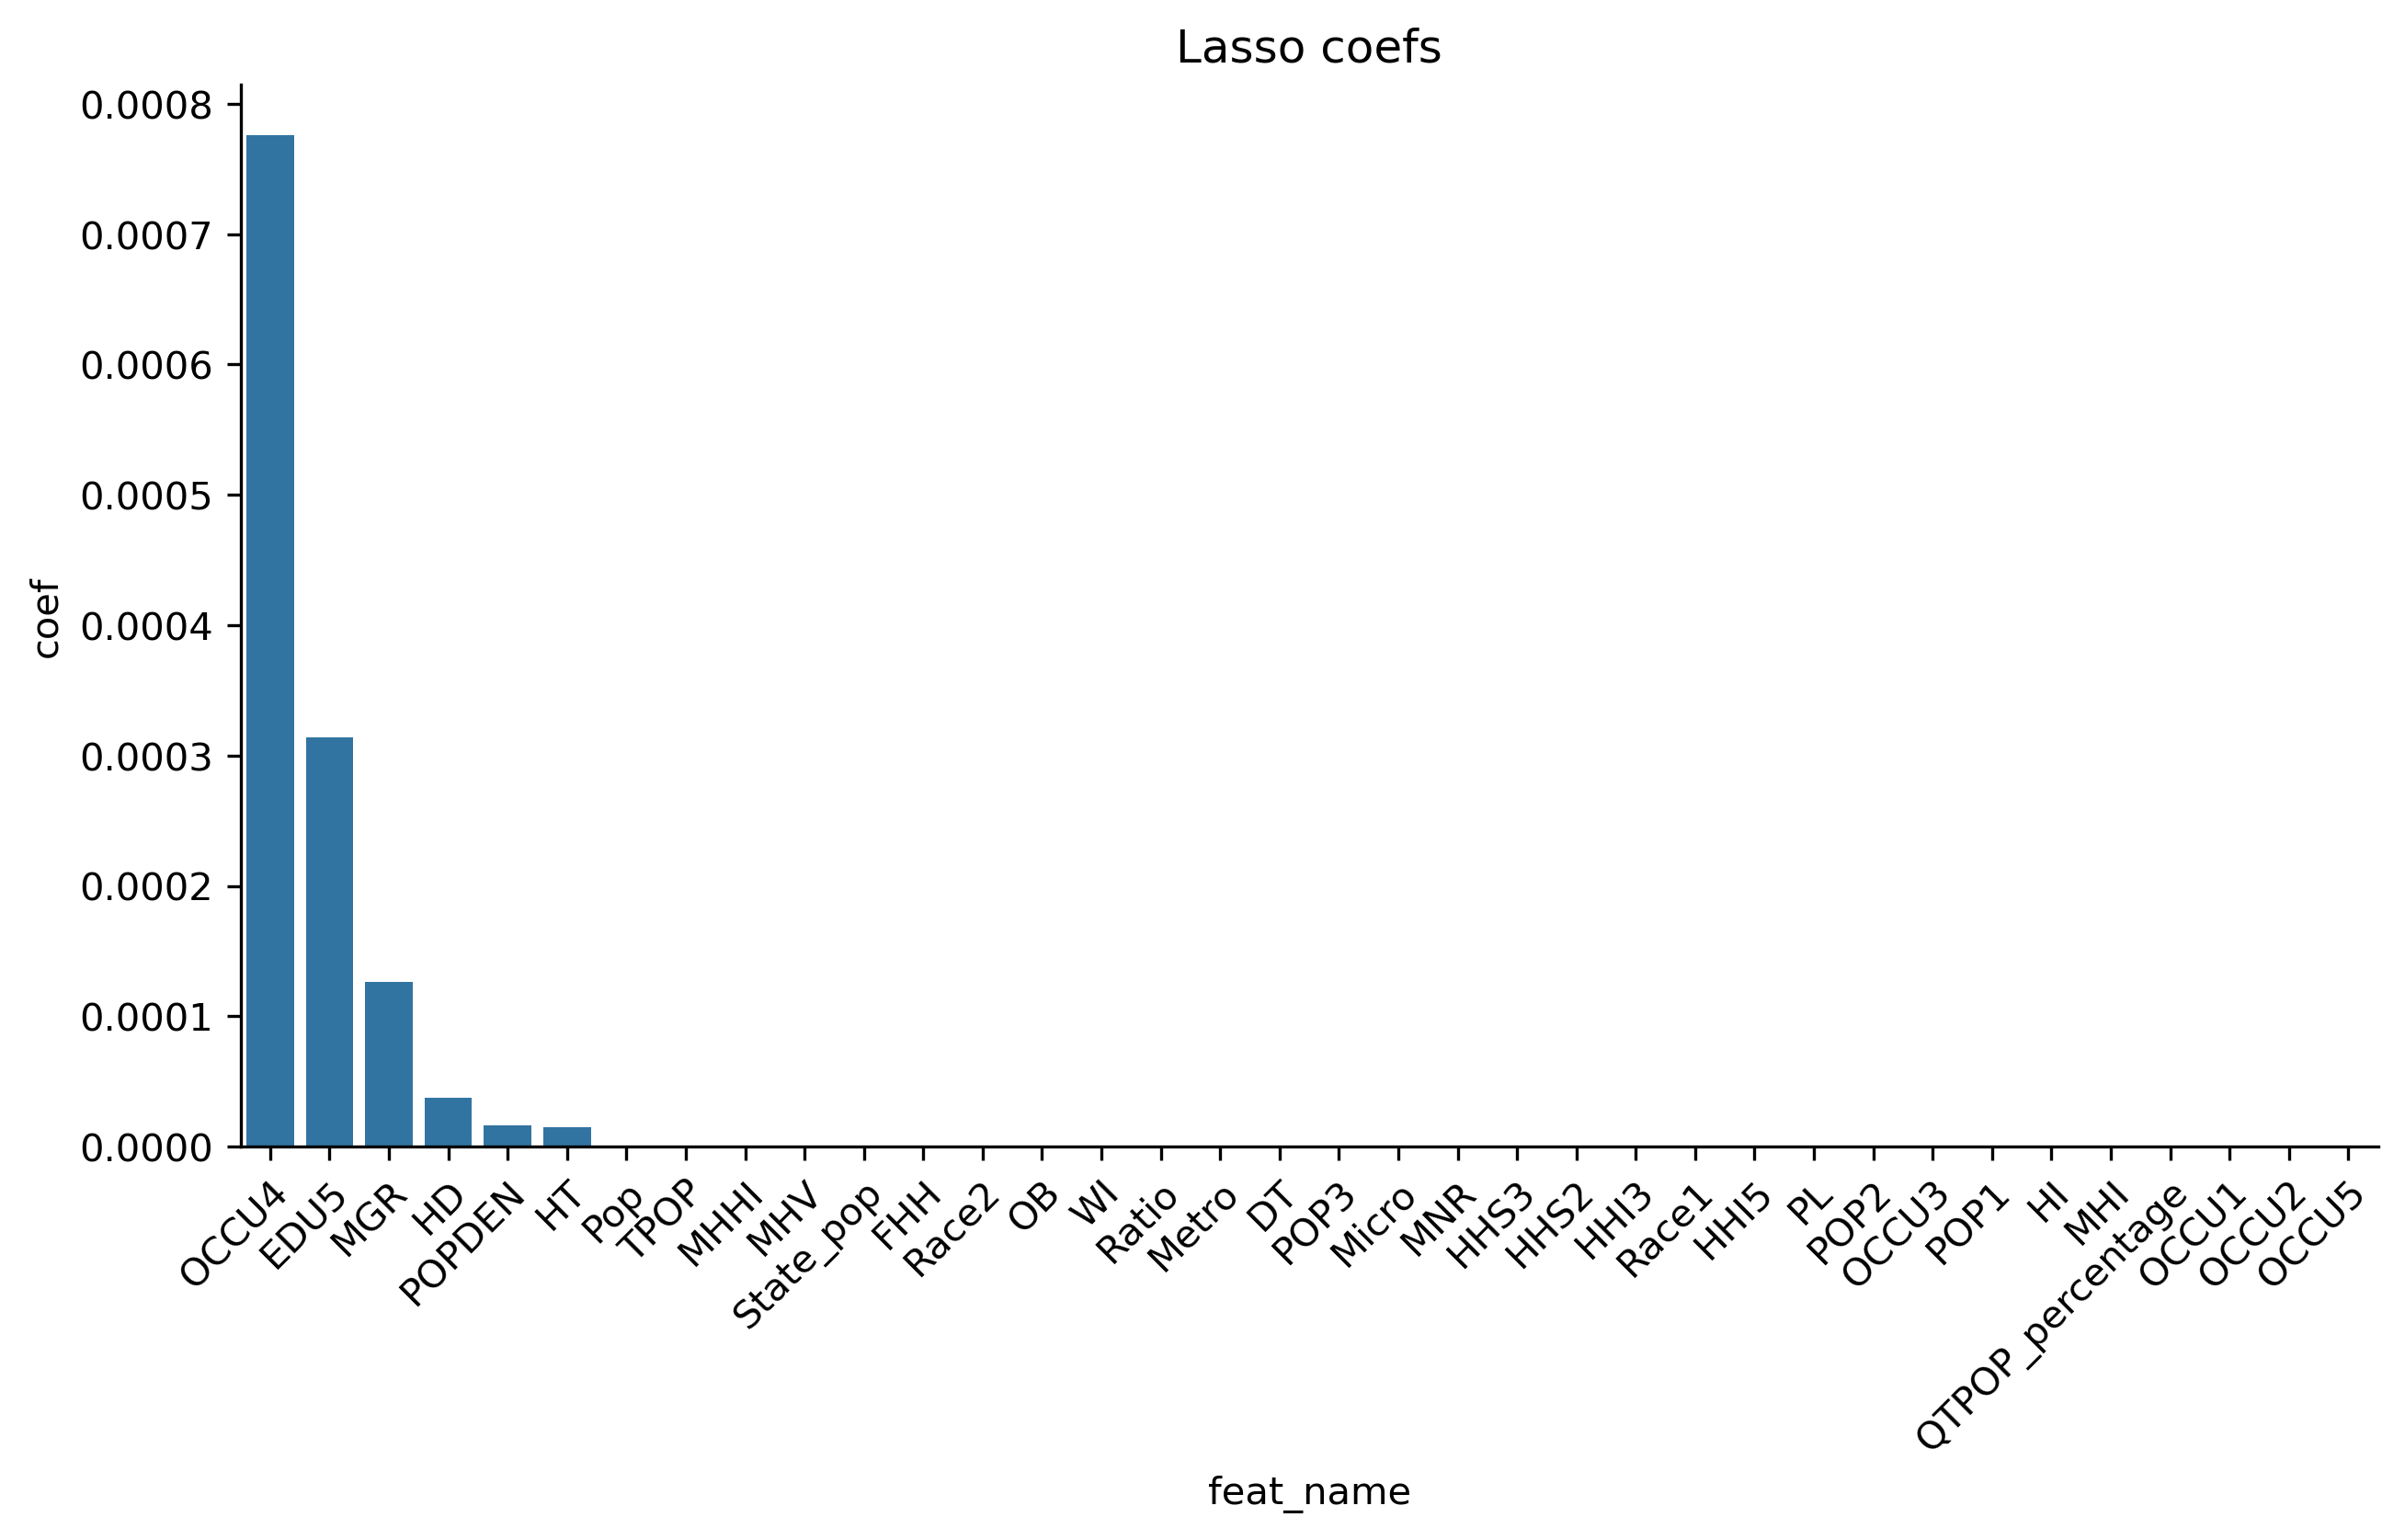

In [137]:
# # # # # # # # # #
how_many = 36
# # # # # # # # # #

# coef = abs(reg.coef_)
total_coefs = np.sum([abs(model.coef_) for model in models], axis=0) 
coef = total_coefs / num_runs

ind = np.argpartition(coef, -how_many)[-how_many:]
top = coef[ind]

df_coefs = X_train.iloc[:, ind]
which_feats = df_coefs.columns

res_df = pd.DataFrame([top, which_feats], index=['coef','feat_name'])
res_df = res_df.T.sort_values(by='coef',inplace=False,ascending=False)

res_df = res_df[:how_many]

import seaborn as sns
import matplotlib.pyplot as plt


DPI = 300

plt.figure(figsize=(10,5))
sns.barplot(res_df, y="coef", x="feat_name", legend=False)
plt.title(f'{alg} coefs')
# plt.xticks(xticks, rotation=45)
plt.xticks(rotation=45,ha='right',wrap='True')

sns.despine()
plt.gcf().set_dpi(DPI)
plt.show()

In [ ]:
meow()

In [ ]:
df_test